# Model: SVM Implementation

Trying out the support vector machine algorithm on the `stellar-classification` dataset, to successfully predict the target variable.

## Preprocess the Data

In [223]:
# import the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

import tensorflow as tf

In [2]:
# load in the dataset
# note: uncomment the following lines to download the dataset
# !kaggle datasets download -d fedesoriano/stellar-classification-dataset-sdss17
# !unzip stellar-classification-dataset-sdss17.zip
# !rm stellar-classification-dataset-sdss17.zip
# !echo 'Dataset Downloaded Successfully'

In [309]:
# read in the dataset
stellar = pd.read_csv("star_classification.csv")
stellar.head()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842


In [4]:
# statistical overview of the dataset
stellar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   obj_ID       100000 non-null  float64
 1   alpha        100000 non-null  float64
 2   delta        100000 non-null  float64
 3   u            100000 non-null  float64
 4   g            100000 non-null  float64
 5   r            100000 non-null  float64
 6   i            100000 non-null  float64
 7   z            100000 non-null  float64
 8   run_ID       100000 non-null  int64  
 9   rerun_ID     100000 non-null  int64  
 10  cam_col      100000 non-null  int64  
 11  field_ID     100000 non-null  int64  
 12  spec_obj_ID  100000 non-null  float64
 13  class        100000 non-null  object 
 14  redshift     100000 non-null  float64
 15  plate        100000 non-null  int64  
 16  MJD          100000 non-null  int64  
 17  fiber_ID     100000 non-null  int64  
dtypes: float64(10), int64(7),

Great! Looks like we have no observations with missing values

In [5]:
# closer look at the features

result = {}
features = stellar.columns

for feature in features:
    if stellar[feature].nunique() > 10:
        result[feature] = stellar[feature].nunique()
    else:
        result[feature] = stellar[feature].unique()
result

{'obj_ID': 78053,
 'alpha': 99999,
 'delta': 99999,
 'u': 93748,
 'g': 92651,
 'r': 91901,
 'i': 92019,
 'z': 92007,
 'run_ID': 430,
 'rerun_ID': array([301]),
 'cam_col': array([2, 5, 3, 4, 6, 1]),
 'field_ID': 856,
 'spec_obj_ID': 100000,
 'class': array(['GALAXY', 'QSO', 'STAR'], dtype=object),
 'redshift': 99295,
 'plate': 6284,
 'MJD': 2180,
 'fiber_ID': 1000}

We see that there are 3 values for our traget variable `class`, namely:

* `GALAXY`
* `QSO`
* `START`

In [6]:
# number of observations
len(stellar)

100000

In [7]:
# reorder the observations based on the class variable
stellar.sort_values('class', axis=0, ascending=True, inplace=True)

In [8]:
# distribution of the classe's observations
# view the layout of the dataset

result = {}
target_labels = stellar['class'].tolist()

for target in target_labels:
    result[target] = -1

for index, obs in enumerate(stellar.values):
    if result[obs[13]] == -1:
        result[obs[13]] = index
result

{'GALAXY': 0, 'QSO': 59445, 'STAR': 78406}

We can now proceed to viewing the distribution of each class in a plot

In [9]:
# visualize using the features: `redshift` and `alpha`
class_labels = stellar['class']
scaled_features = StandardScaler().fit_transform(stellar.drop('class', axis=1))
scaled_stellar = pd.DataFrame(scaled_features, index=stellar.index, columns=(stellar.drop('class', axis=1)).columns)

scaled_stellar['class'] = class_labels
scaled_stellar

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,redshift,plate,MJD,fiber_ID,class
0,-0.445634,-0.434604,0.425529,0.059755,0.054926,0.403962,0.046007,0.003937,-0.445535,0.0,-0.952553,-0.718947,0.228609,0.079557,0.228633,0.423203,-1.021342,GALAXY
58230,-1.139298,-0.368710,1.379317,-0.000092,0.031505,0.903290,1.010382,0.053337,-1.139260,0.0,-0.322395,-0.121673,0.731651,0.485616,0.731633,0.802528,0.986019,GALAXY
58228,-1.139298,-0.381213,1.351881,0.045294,0.047447,0.809590,0.974606,0.053707,-1.139260,0.0,-0.322395,-0.161939,0.731256,-0.439343,0.731294,0.805846,-1.516760,GALAXY
58227,-1.070015,0.480361,-1.322346,0.006342,0.031496,0.476575,0.233830,0.007300,-1.070040,0.0,0.307763,-0.584728,-0.378349,-0.092486,-0.378354,-0.141914,0.108945,GALAXY
58226,-1.070015,0.405437,-1.327688,0.112584,0.011681,-0.286498,-0.398618,-0.022590,-1.070040,0.0,0.307763,-0.906853,-1.429054,-0.218501,-1.429064,-1.760957,0.090596,GALAXY
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46329,-1.092601,0.766323,0.734251,0.045131,0.016127,0.035459,0.100766,0.011344,-1.092435,0.0,-1.582710,-0.953830,1.893737,-0.789715,1.893782,1.470494,-1.509421,STAR
46330,-0.296055,0.617464,0.094237,-0.139661,-0.129397,-2.011636,-1.917283,-0.096359,-0.295898,0.0,-1.582710,3.294198,-0.907107,-0.789845,-0.907096,-0.577640,-0.691063,STAR
46331,-2.124159,-0.701998,-1.226114,0.014384,-0.030837,-0.636966,-0.606623,-0.028993,-2.124116,0.0,-0.322395,-1.088049,0.783445,-0.788944,0.783457,0.626690,-0.335096,STAR
75082,-1.700567,-0.203089,-1.300428,-0.000616,0.010098,0.515621,0.775514,0.049766,-1.700653,0.0,0.937920,-1.020939,-0.457924,-0.787913,-0.457953,-0.174538,1.173177,STAR


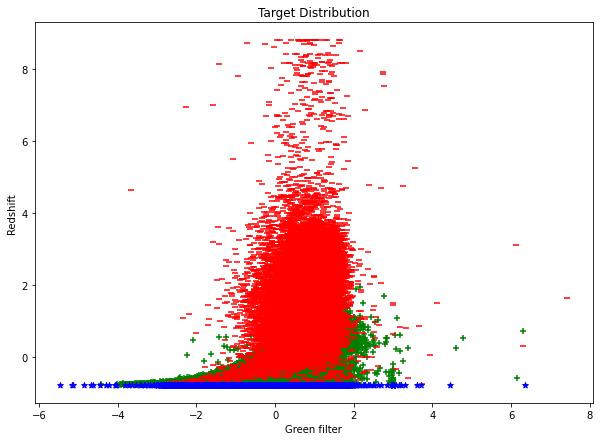

In [10]:

x_data = scaled_stellar['i']
y_data = scaled_stellar['redshift']

galaxy_x = x_data[:59445]
galaxy_y = y_data[:59445]

qso_x = x_data[59445:78406]
qso_y = y_data[59445:78406]

star_x = x_data[78406:]
star_y = y_data[78406:]

# create the figure
plt.figure(figsize=(10,7))
plt.scatter(galaxy_x,galaxy_y,marker='+',color='green')
plt.scatter(qso_x,qso_y,marker='_',color='red')
plt.scatter(star_x,star_y,marker='*',color='blue')

plt.title("Target Distribution")
plt.xlabel("Green filter")
plt.ylabel("Redshift")
plt.show()

### Feature Engineer Phase

In [310]:
# encode values for class column
stellar.replace({'class': {'GALAXY': 0, 'STAR': 1, 'QSO':2}}, inplace=True)

# remove all columns containing ID at the end
cleaned = stellar.drop(stellar.filter(regex='ID$').columns, axis=1)

# drop the date column
cleaned = stellar.drop('MJD', axis=1)

In [12]:
# make the X and y varialbes (all features)
X_all = cleaned.drop('class', axis=1)
y = cleaned['class']

In [311]:
# keep the 2 features
features = cleaned.columns.tolist()
features.remove('redshift')
features.remove('g')

# make the X and y varialbes
X_specifc = cleaned.drop(features, axis=1)

In [314]:
sc = StandardScaler()
yj = PowerTransformer(method="yeo-johnson")

preprocessor = ColumnTransformer([("norm", yj, selector(dtype_include="number")),
                ("std_encode", sc, selector(dtype_include="number"))
                ])

## Build Phase

* Using all features

In [30]:
# initialize an SVC model (all features)
X_train, X_test, y_train, y_test = train_test_split(X_all, y, train_size=0.7, random_state=123)

svc_clf = SVC(kernel='rbf')
svc_model_pipeline = Pipeline(steps=[
  ("preprocessor", preprocessor),
  ("model", svc_clf),
])
# train the model on our dataset
svc_model_pipeline.fit(X_train,y_train)
# store the predictions of the model
y_pred = svc_model_pipeline.predict(X_test)
# evaluate the model on accuracy
print(accuracy_score(y_test,y_pred))

In [315]:
# initialize an SVC model (2 features)
X_train, X_test, y_train, y_test = train_test_split(X_specifc, y, train_size=0.7, random_state=123)

svc_clf = SVC(kernel='rbf')
# train the model on our dataset
svc_model_pipeline = Pipeline(steps=[
  ("preprocessor", preprocessor),
  ("model", svc_clf),
])
svc_model_pipeline.fit(X_train,y_train)
# store the predictions of the model
y_pred = svc_model_pipeline.predict(X_test)
# evaluate the model on accuracy
print(accuracy_score(y_test,y_pred))

0.9644666666666667


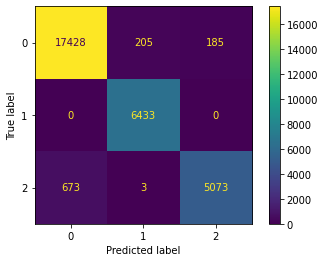

In [343]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

In [345]:
# {'class': {'GALAXY': 0, 'STAR': 1, 'QSO':2}}

array([0, 2, 1])

### Using Deep Learning

In [225]:
# re-read in the dataset
stellar = pd.read_csv("star_classification.csv")
stellar.head()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842


- Feature Engineering

In [226]:
# encode values for class column
stellar.replace({'class': {'GALAXY': 0, 'STAR': 1, 'QSO':2}}, inplace=True)

# remove all columns containing ID at the end
cleaned = stellar.drop(stellar.filter(regex='ID$').columns, axis=1)

# drop the date column
cleaned = cleaned.drop('MJD', axis=1)

# make the X and y varialbes
X = cleaned.drop(['class'], axis=1)
y = cleaned['class']

# split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=123)

In [300]:
X_train

,alpha,delta,u,g,r,i,z,cam_col,redshift,plate
52308,48.573323,-0.609684,18.80211,16.75706,15.66640,15.20351,14.80488,2,0.115262,412
27380,260.094957,27.014951,20.26815,18.68293,18.09193,17.86272,17.77524,1,-0.000209,2193
94588,135.477289,37.187920,24.05482,21.67747,20.38921,19.56683,19.27142,2,0.538213,4608
7361,118.180524,9.267706,20.56594,19.53276,19.22361,18.98544,18.89350,4,0.000171,2945
52298,15.024146,4.027261,24.63314,20.48507,18.76055,18.10046,18.07149,1,0.322435,4309
...,...,...,...,...,...,...,...,...,...,...
63206,115.884742,20.139136,18.93230,17.66927,17.21911,16.99153,16.88261,4,0.000022,1263
61404,133.430333,-0.719735,19.83167,19.90659,19.58608,19.57696,19.64975,2,1.309977,12533
17730,255.223294,23.638965,18.99455,18.04598,17.63787,17.44783,17.38555,3,-0.000624,3290
28030,232.458207,36.143802,20.20453,18.46623,17.64739,17.25447,16.98376,3,0.065986,1401


In [301]:
sc = StandardScaler()
yj = PowerTransformer(method="yeo-johnson")

preprocessor = ColumnTransformer([("normalization", yj, selector(dtype_include="number")),
                ("standardization", sc, selector(dtype_include="number")),
                ])

- Building a model

In [302]:
deep_model = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation='tanh'),
    tf.keras.layers.Dense(64, activation='tanh'),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [303]:
# compile the model
deep_model.compile(
    loss= 'sparse_categorical_crossentropy',
    optimizer= tf.keras.optimizers.SGD(),
    metrics= ['accuracy']
)

In [304]:
# create the pipeline
deep_model_pipeline = Pipeline(steps=[
  ("preprocessor", preprocessor),
  ("model", deep_model),
])

In [308]:
deep_model_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('normalization',
                                                  PowerTransformer(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x148b62980>),
                                                 ('standardization',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x148b61b40>)])),
                ('model',
                 <keras.engine.sequential.Sequential object at 0x148b61ab0>)])

In [346]:
deep_model.summary()

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_114 (Dense)           (None, 512)               10752     
                                                                 
 dense_115 (Dense)           (None, 64)                32832     
                                                                 
 dense_116 (Dense)           (None, 3)                 195       
                                                                 
Total params: 43,779
Trainable params: 43,779
Non-trainable params: 0
_________________________________________________________________


In [305]:
# fit the model
deep_model_history = deep_model_pipeline.fit(X_train,y_train, model__epochs=10, model__validation_split=0.2)

Epoch 1/10
1750/1750 [==============================] - 13s 7ms/step - loss: 0.2560 - accuracy: 0.9258 - val_loss: 0.1757 - val_accuracy: 0.9546
Epoch 2/10
1750/1750 [==============================] - 15s 9ms/step - loss: 0.1625 - accuracy: 0.9552 - val_loss: 0.1501 - val_accuracy: 0.9616
Epoch 3/10
1750/1750 [==============================] - 15s 8ms/step - loss: 0.1418 - accuracy: 0.9596 - val_loss: 0.1336 - val_accuracy: 0.9631
Epoch 4/10
1750/1750 [==============================] - 16s 9ms/step - loss: 0.1318 - accuracy: 0.9618 - val_loss: 0.1279 - val_accuracy: 0.9635
Epoch 5/10
1750/1750 [==============================] - 20s 11ms/step - loss: 0.1261 - accuracy: 0.9629 - val_loss: 0.1235 - val_accuracy: 0.9656
Epoch 6/10
1750/1750 [==============================] - 21s 12ms/step - loss: 0.1225 - accuracy: 0.9641 - val_loss: 0.1209 - val_accuracy: 0.9651
Epoch 7/10
1750/1750 [==============================] - 21s 12ms/step - loss: 0.1199 - accuracy: 0.9644 - val_loss: 0.1174 - val

In [ ]:
y_pred = deep_model_pipeline.predict(X_test)
accuracy_score(y_test, y_pred.argmax(axis=-1))

0.9713333333333334